In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import seaborn as sb
plt = sb.mpl.pyplot

In [36]:
from matplotlib.colors import LogNorm

In [3]:
def mean_nsig(Phi0, gamma, accept, dec):
    r"""
    Phi0 : float, flux in 1/GeV cm^2 s
    gamma: float, spectral index e.g. -2
    accept: 2D histogram, [x,y,z]
    dec: float, declination position in degree
    """
    return Phi0*acceptance(dec, gamma, accept)


In [209]:
def energyPDF_signal(logE, cos_tta, gamma):
    r""" 
    Functional form of the energy PDF, sum of 3 gaussians
    logE : float, logarithm of energy in GeV
    cos_tta : float, cos theta in detector coordinates
    gamma : float, spectral index e.g. -2    
    """
    y = logE - 3.5
    val = 0.
    if cos_tta<0.2:
        # parameter matrix 6 x 3
        aa = np.array([[-0.4956, -0.7173, -0.2009],
              [1.0921, 0.9686, -0.3792], 
              [-0.9931, 0.2203, 0.1670],
              [0.0274, -0.5368, 0.1734], 
              [0.1376, 0.3141, -0.1768], 
              [-0.0337, -0.0547, 0.0367]])


    elif cos_tta>=0.2 and cos_tta<0.6: 
        # parameter matrix 7 x 4
        aa = np.array([[-0.2683,-0.3559,-0.2586,0.0720],
              [0.2999,0.9038,-0.2066,-0.1506], 
              [-0.4521,-0.2401,0.2303,0.1689],
              [0.2152,-0.0583,-0.1187,0.0954], 
              [-0.3982,0.4155,-0.2141,-0.1889], 
              [0.2331,-0.2681,0.2227,0.035],
              [-0.0417,0.0496,-0.0534,0.0095]])
    

    elif cos_tta>0.6:
        # parameter matrix 9 x 4
        aa = np.array([[-0.2787,0.0233,-0.2713,0.0220], 
              [-0.0272,0.7206,-0.1626,-0.0635], 
              [-0.1022,-0.0034,0.1250,-0.0039],
              [-0.8864,0.1734,0.0093,0.0289], 
              [0.3290,-0.1563,-0.1670,0.1391],
              [0.7119,-0.0794,0.0544,-0.0947], 
              [-0.7631,0.1706,0.0817,-0.0895], 
              [0.2790,-0.0815,-0.0545,0.0823], 
              [-0.0356,0.0126,0.0090,-0.0162]])
    else:
        print("Outside declination range, what did you do?!")
        
    a = np.array([np.sum(np.poly1d(np.flip(a_i, axis=0))(gamma+2.2)) for a_i in aa])
    #val = np.sum(np.poly1d(np.flip(a, axis=0))(y))
    val = np.power(10, np.sum(np.poly1d(np.flip(a, axis=0))(y)))
    return val

In [296]:
def get_costta_fromsource(decrad, seed=None):
    r"""
    dec : float, declination
    """
    rs = np.random.RandomState(seed)
    lat_ANT = np.radians(42.798917)
    ct = -1
    it = 0
    while ct<-0.1 and it<1000:
        HA = rs.uniform(0.,2*np.pi)
        ct = -np.sin(lat_ANT)*np.sin(decrad) + np.cos(lat_ANT)*np.cos(decrad)*np.cos(HA)
        it += 1
    if ct<-0.1: ct = -0.1
    return ct


12


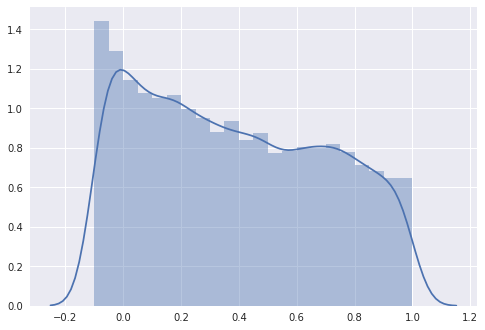

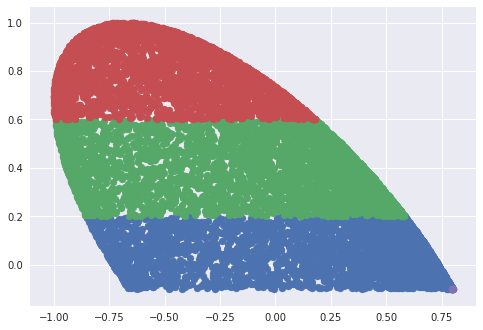

In [299]:
num = 10000
dec = np.arcsin(np.linspace(-1.,0.8, num=num))
ct = np.zeros((num,))
for i,dd in enumerate(dec):
    ct[i] += get_costta_fromsource(dd)
    
mask = ct<=-0.1
mask1 = np.logical_and(ct>-0.1, ct<0.2)
mask2 = np.logical_and(ct>=0.2, ct<0.6)
mask3 = ct>0.6
sb.distplot(ct[~mask])
plt.figure()
plt.scatter(np.sin(dec[mask1]),ct[mask1])
plt.scatter(np.sin(dec[mask2]),ct[mask2])
plt.scatter(np.sin(dec[mask3]),ct[mask3])
plt.scatter(np.sin(dec[mask]),ct[mask])



print np.count_nonzero(mask)

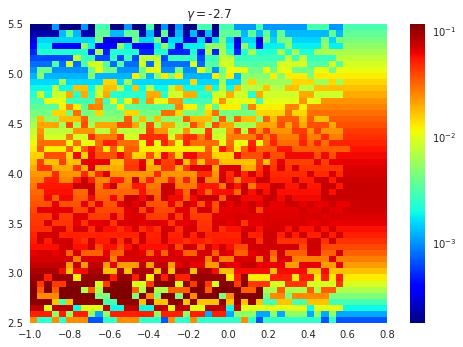

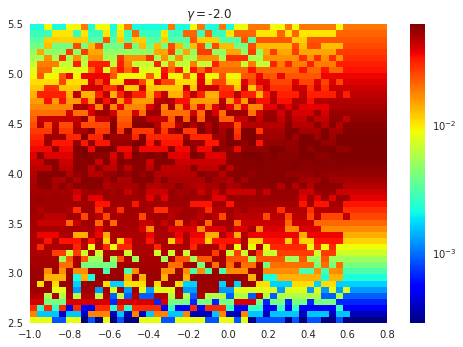

In [301]:
num = 50
e_range = [2.5, 5.5]
logE = np.linspace(*e_range, num=num)
sd_range = [-1, 0.8]
sindec = np.linspace(*sd_range, num=num)
gamma = [-2.7, -2.]
average_over = 10
c_t = []
for g in gamma:
    mean_tot = np.zeros((num, num))
    for _ in xrange(average_over):
        tot = np.zeros((num, num))
        for i,le in enumerate(logE):
            res = np.zeros((num,))
            for j,sd in enumerate(sindec):
                ct = get_costta_fromsource(np.arcsin(sd))
                c_t.append(ct)
                res[j] = energyPDF_signal(le, ct, g)
            tot[i] = res
    mean_tot += tot*1./average_over
    plt.figure()
    ax = plt.pcolor(sindec,
                    logE,
                    mean_tot,
                    norm=LogNorm(),
                    cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlim(sd_range)
    plt.ylim(e_range)
    plt.title(r"$\gamma=${}".format(g))


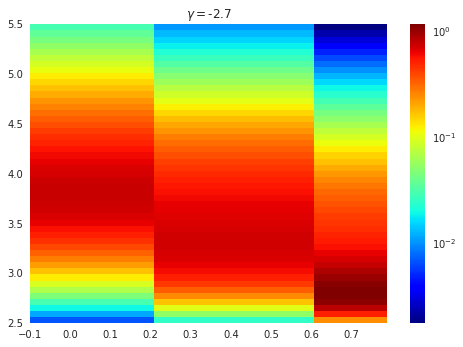

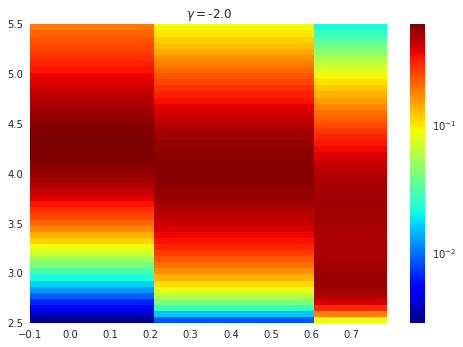

In [302]:
num = 50
e_range = [2.5, 5.5]
logE = np.linspace(*e_range, num=num)
ct_range = [-0.1, 0.79]
ctt = np.linspace(*ct_range, num=num)
gamma = [-2.7, -2.]
c_t = []
for g in gamma:
    tot = np.zeros((num, num))
    for i,le in enumerate(logE):
        res = np.zeros((num,))
        for j,ct in enumerate(ctt):
            res[j] = energyPDF_signal(le, ct, g)
        tot[i] = res
    plt.figure()
    ax = plt.pcolor(ctt,
                    logE,
                    tot,
                    norm=LogNorm(),
                    cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlim(ct_range)
    plt.ylim(e_range)
    plt.title(r"$\gamma=${}".format(g))


In [305]:
def energyPDF_bkg(logE, cos_tta):
    r"""
    double logE=x[0];
    double cos_tta=params[0];
    """
    y = logE - 3.5
    val = 0.

    if cos_tta<0.2:
        # shape 3x3
        a = np.array([[0.566, 3.33, 0.263], 
             [0.5938, 3.898, 0.42], 
             [0.0112, 2.51, 0.13]])
        
        val = np.sum(a[:,0]*np.exp(-0.5*(logE-a[:,1])**2/(a[:,2]**2)))
        return val

    elif cos_tta>=0.2 and cos_tta<0.6:
        a = [-0.1704, -0.697, -0.286, 0.613, -0.911, 0.02591, 4.5, 0.34] # len = 8

    if cos_tta>0.6:
        a = [-0.6003,-0.9204,0.7289,-0.8201,-2.0816, 0.01105, 4.3, 0.3] # len = 8 = 5 + 3
    e = np.sum(np.poly1d(np.flip(a[:5], axis=0))(y))
    val = np.power(10., e)
    val += a[5]*np.exp(-0.5*(logE-a[6])**2/(a[7]**2))
    return val


In [322]:
from scipy.interpolate import SmoothBivariateSpline

Text(0.5,1,'background')

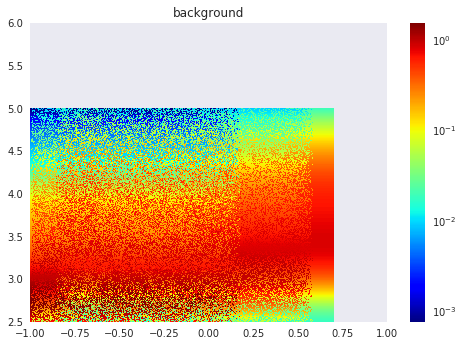

In [386]:
num = 500
e_range = [2.5, 5.]
logE = np.linspace(*e_range, num=num)
sd_range = [-1, 0.7]
sindec = np.linspace(*sd_range, num=num)
tot = np.zeros((num, num))
for i,le in enumerate(logE):
    res = np.zeros((num,))
    for j,sd in enumerate(sindec):
        ct = get_costta_fromsource(np.arcsin(sd))
        res[j] = energyPDF_bkg(le, ct)
    tot[i] = res
    

plt.figure()
ax = plt.pcolor(sindec,
                logE,
                tot,
                norm=LogNorm(),
                cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(-1,1)
plt.ylim(2.5, 6)
plt.title("background")


In [382]:
from scipy.ndimage.filters import gaussian_filter

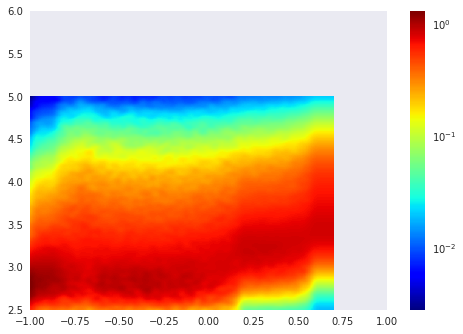

In [388]:
ax = plt.pcolor(sindec,
                logE,
                gaussian_filter(tot, sigma=5),
                norm=LogNorm(),
                cmap=plt.cm.jet)
plt.xlim(-1,1)
plt.ylim(2.5, 6)
plt.colorbar()

In [397]:
from os.path import join

import glob

['/home/lschumacher/antares/LL_ingredients/Bkg_PDF.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam18.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam19.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam20.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam21.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam22.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam23.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam24.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam25.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam26.dat', '/home/lschumacher/antares/LL_ingredients/Sig_PDF_Gam27.dat']


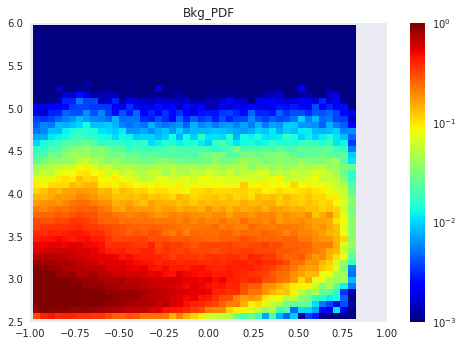

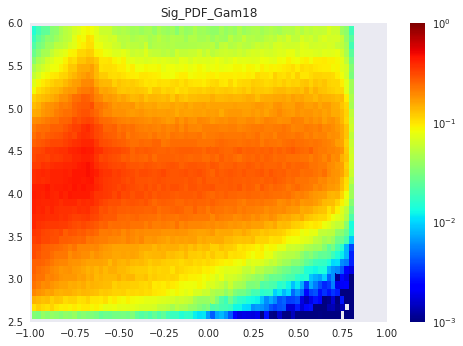

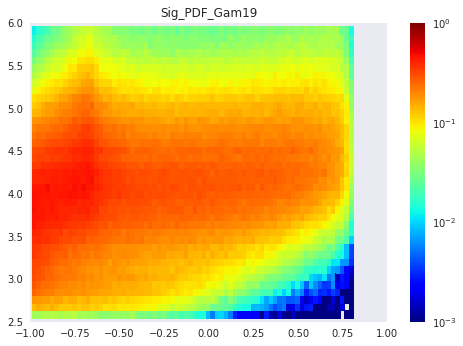

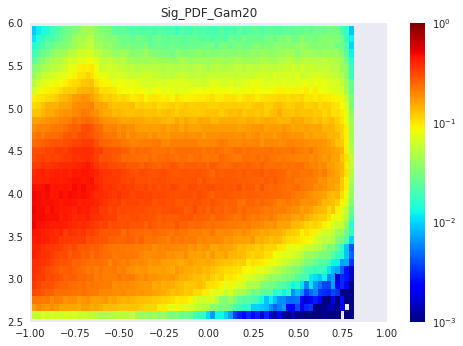

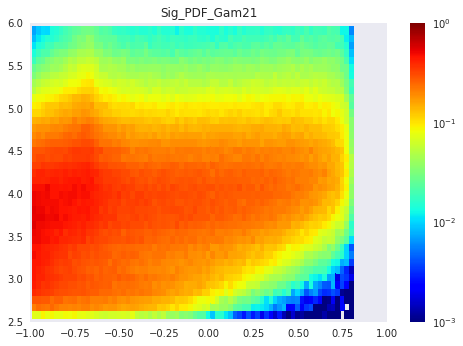

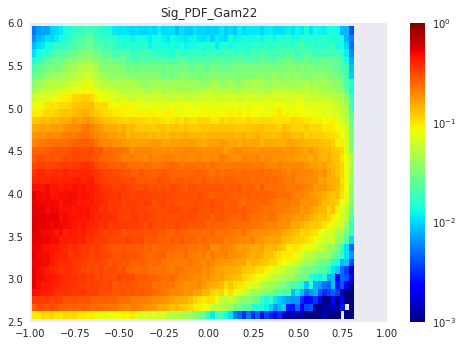

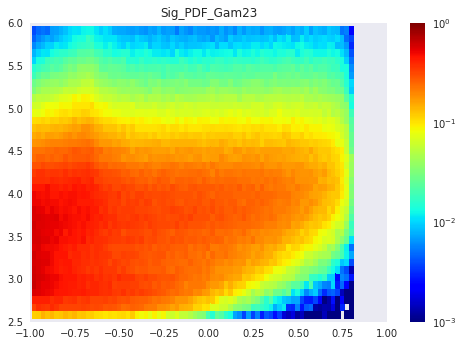

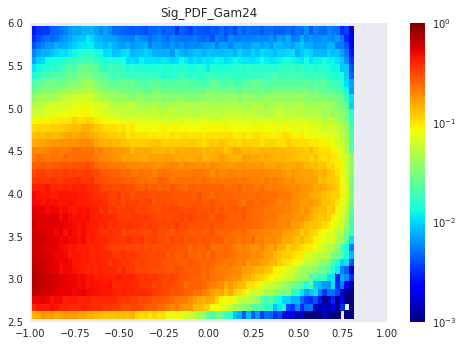

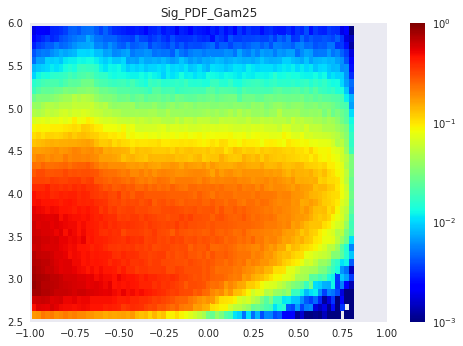

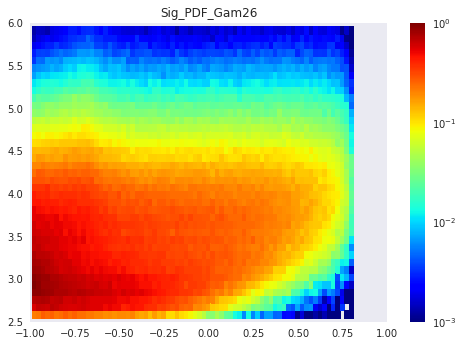

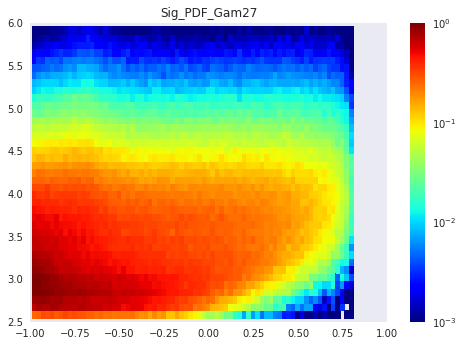

In [401]:
ant_path = "/home/lschumacher/antares/LL_ingredients/"

files = sorted(glob.glob(join(ant_path, "*")))
print files
vmax = 1
vmin = 1e-3
data_dict = dict()

for f in files:
    data = np.genfromtxt(f)
    xbins = len(np.unique(data[:,0]))
    ybins = len(np.unique(data[:,1]))
    plt.figure()
    ax = plt.pcolor(data[:,0].reshape(xbins, ybins), 
                    data[:,1].reshape(xbins, ybins), 
                    data[:,2].reshape(xbins, ybins),
                    vmin=vmin,
                    vmax=vmax,
                    norm=LogNorm(),
                    cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlim(-1,1)
    plt.ylim(2.5, 6)
    identifier = f.split("/")[-1].split(".")[0]
    plt.title(identifier)
    data_dict[identifier] = np.copy(data)

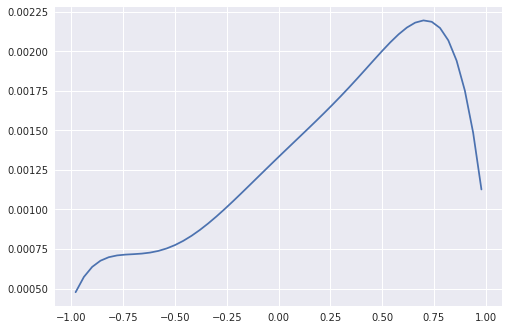

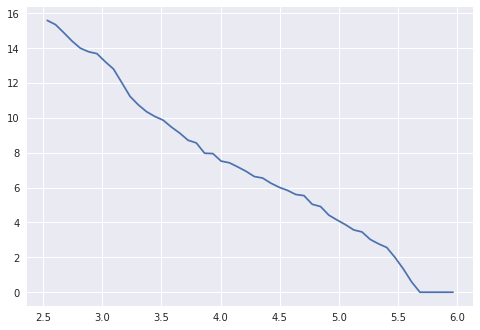

In [505]:
data = np.copy(data_dict["Bkg_PDF"])
xbins = len(np.unique(data[:,0]))
ybins = len(np.unique(data[:,1]))
data_1d_x = data[:,2].reshape(xbins, ybins).sum(axis=0)
plt.figure()
sindec = np.unique(data[:,0])
#plt.plot(sindec, data_1d_x, "o")

data_1d_y = data[:,2].reshape(xbins, ybins).sum(axis=1)
plt.figure()
plt.plot(np.unique(data[:,1]), data_1d_y)

In [395]:
def costtaPDF_bkg(cos_tta):
    r""" Defined on {-0.1, 1} """
    y = cos_tta - 0.5
    a = [0.920354,1.35499,0.71129,-7.88656,-6.18286,20.7857,17.8463]
    val = np.sum(np.poly1d(np.flip(a, axis=0))(y))
    return val


In [406]:
from scipy.integrate import quad

from scipy.interpolate import InterpolatedUnivariateSpline

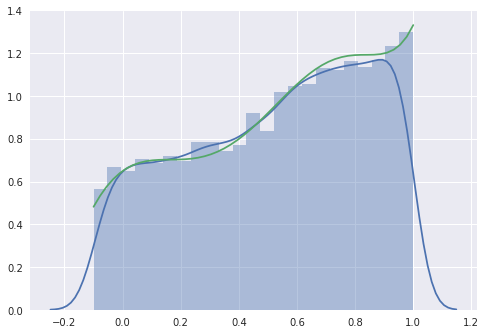

In [443]:
ct_rn = draw_from_1d_function(costtaPDF_bkg, -0.1, 1, int(1e4))

sb.distplot(ct_rn)
x = np.linspace(-0.1, 1)
plt.plot(x, np.vectorize(costtaPDF_bkg)(x))
del ct_rn

In [444]:
def costtaPDF_signal(cos_tta, gamma):
    y = gamma + 2.2
    # shape 8 x 3
    ab = [[0.826,1.094,0.704],
          [-0.002,-2.988,-3.574],
          [-4.487,-14.386,-14.031],
          [46.667,136.790,129.060],
          [-159.483,-451.568,-379.438],
          [257.411,710.249,546.235],
          [-199.602,-540.627,-385.761],
          [59.464,160.436,106.978]]
    a = [np.sum(np.poly1d(np.flip(ai, axis=0))(y)) for ai in ab]
    val = np.sum(np.poly1d(np.flip(a, axis=0))(cos_tta))
    return val

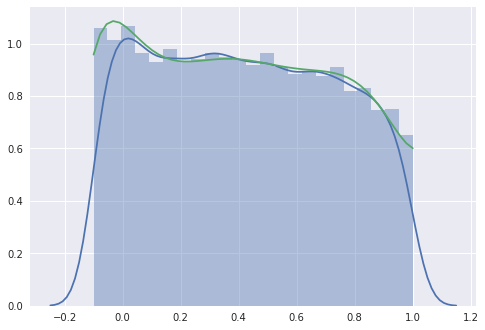

In [445]:
ct_rn = draw_from_1d_function(lambda x: costtaPDF_signal(x,-2), -0.1, 1, int(1e4))

sb.distplot(ct_rn)
x = np.linspace(-0.1, 1)
plt.plot(x, np.vectorize(lambda x: costtaPDF_signal(x,-2))(x))
del ct_rn

In [392]:
def psf2D_gamma(ra, dec, ra_0, dec_0, gamma):
    r"""
    all in arrays?
    ra, dec: float, position in radian
    ra_0, dec_0: float, source position in radian
    gamma : float, source spectral index
    """
    # shape 5 x 4
    b = [[6.807,6.149,3.888,0.865],
         [115.115,182.058,96.405,16.482],
         [-465.904,-789.718,-428.301,-74.354],
         [697.181,1217.255,706.056,129.503],
         [-257.106, -710.004, -432.294, -76.251]]

    # double a[5];
    a = np.array([np.sum(np.poly1d(np.flip(bj, axis=0))(gamma)) for bj in b])
    

    sindec = np.sin(dec)
    cosdec = np.sqrt(1.- sindec**2)
    cosa = np.cos(dec_0)*cosdec*np.cos(ra-ra_0) + np.sin(dec_0)*sindec
    sina = np.sqrt(1.-cosa**2)
    ang = np.degrees(np.arccos(cosa))

    if np.abs(ang<0.001): return a[0]

    num = a[0]*ang
    denom = 1. + np.sum(np.poly1d(np.flip(a, axis=0))(ang))
    return num/(sina*denom)

[]

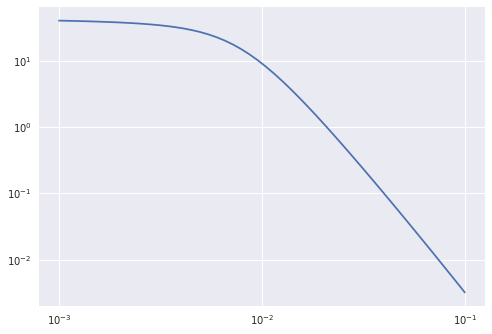

In [394]:
ra_0 = 0.
dec_0 = 0.
num = 50
ra = np.zeros((num,))
dec = np.logspace(-3, -1, num=num)
gamma = -2

res = np.empty((num,))
for i,(rr,dd) in enumerate(zip(ra,dec)):
    res[i] = psf2D_gamma(rr,dd,ra_0,dec_0,gamma)
plt.plot(dec, res)
plt.loglog()

In [179]:
from scipy.interpolate import RectBivariateSpline

In [203]:
def acceptance(dec, gamma, accept_hist):
    r"""
    dec : float, degree
    gamma : float, negative
    Accept : 2D histogram, i.e. [x,y,z]
    """
    x = np.sin(np.radians(dec))
    accept_spline = RectBivariateSpline(accept_hist[0], accept_hist[1], accept_hist[2])
    return accept_spline(x, gamma)
    

In [506]:
def draw_from_1d_function(func, xmin, xmax, n, rs=np.random.RandomState()):
    func = np.vectorize(func)
    x = np.linspace(xmin, xmax)
    f_int = np.vectorize(lambda x: quad(func, xmin, x)[0])
    y_int = np.array(f_int(x))
    f_int_inv = InterpolatedUnivariateSpline(y_int, x)
    
    rn = rs.uniform(0,1,size=n)
    return np.vectorize(f_int_inv)(rn)

In [ ]:
def draw_from_2d_histogram(hist, rs=np.random.RandomState()):

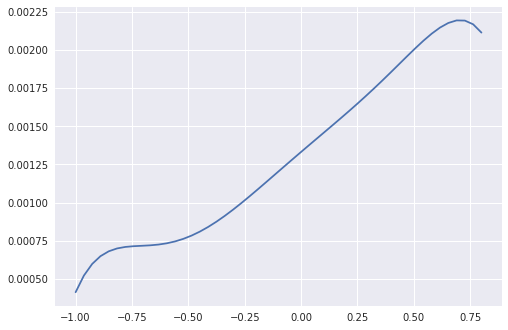

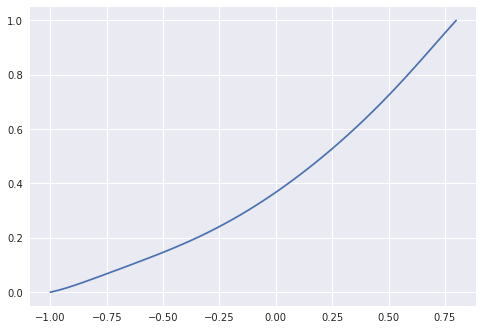

In [528]:
def sindec_bg(x):
    coeff = np.flip([364.506, 345.625, -32.7001, 40.4673, 554.757, -318.45, -705.982], axis=0)/(360.*760.334)
    return np.poly1d(coeff)(x)

x = np.linspace(-1, 0.8)
plt.plot(x, sindec_bg(x))
plt.figure()
s_int = np.vectorize(lambda x: quad(sindec_bg, -1, x)[0]/quad(sindec_bg, -1, 0.8)[0])
plt.plot(x, s_int(x))

In [523]:
def draw_events(nbkg, seed=None):
    r"""
    int nbkg, double Phi0, double gamma, TH2D* Accept, vector<Source> & Sources
    
    """
    event_fields = ["ra", "dec", "logE"] #, "sigma"]
    rs = np.random.RandomState(seed)
    nb = rs.poisson(nbkg)
    events = np.zeros((nb,), dtype=[(name, np.float) for name in event_fields])

    #// &&&&&&&  BKG &&&&&&&&&&&&&&&&&
    events["ra"] = rs.uniform(0., np.pi*2, size=nb) # radian
    events["dec"] = draw_from_1d_function(sindec_bg, -1, 0.8, nb, rs)
    #cos_tta = draw_from_1d_function(costtaPDF_bkg, -0.1, 1, nb, rs=rs)  
    """bE = lambda logE: energyPDF_bkg(logE, cos_tta)
    events["logE"] = draw_from_1d_function(bE, 2.5, 6, nb, rs=rs) 
    #events["dec"] = np.arcsin(draw_from_1d_function(bk, -1., 0.8, nb, rs=rs)) # radian
    """
    return events

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arcsin
  del sys.path[0]


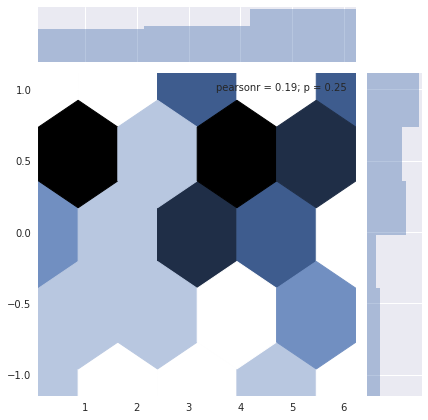

In [524]:
events = draw_events(int(1e4), seed=1)
sb.jointplot(events["ra"], events["dec"], kind="hex")
del events

In [ ]:
vector<Event> DrawEvts(int nbkg, double Phi0, double gamma, TH2D* Accept, vector<Source> & Sources){
  double Costta,Energy,Lambda,Beta,Ra,Dec;
  double dec_source,ra_source;

  // ********** Bkg pdfs ******************
  TF1 bC=TF1("Cttapdf",,-0.1,1,0);
  TF1 bk=TF1("bkg_sindec"," (364.506-345.625*x -32.7001*x*x + 40.4673*x*x*x+554.757*TMath::Power(x,4)-318.45*TMath::Power(x,5)-705.982*TMath::Power(x,6) ) /(360.*760.334)",-1.,0.8);
  TF1 bE=TF1("Epdf",EnergyPDF_Bkg,2.5,6,1);

  //******** Signal pdfs **********************
  TF1 sE=TF1("sEpdf",E_PDF_dEdX_Sig_Gamma,2.5,6,2);
  //**********************************************************

  TRandom2 rat=TRandom2();rat.SetSeed(0);
  int nb=rat.Poisson(nbkg);
  vector<Event> Evts(nb);

  // &&&&&&&  BKG &&&&&&&&&&&&&&&&&
  for (int i=0;i<nb;i++){
    Costta=bC.GetRandom();  bE.SetParameter(0,Costta);
    Energy=bE.GetRandom();  // get energy here
    Dec=asin(bk.GetRandom())*180./M_PI; Ra=rat.Uniform(360.); Beta=rat.Uniform(1.); // get position here
    Event evt(Energy,Costta,Lambda,Beta,Ra,Dec);
    Evts.at(i)=evt;
  }

  //&&&&&&&&&& Signal &&&&&&&&&&&&&&&&&&&&&
  if (Phi0<=0.) return Evts;

  for (unsigned int i=0;i<Sources.size();i++){  // loop on all the sources considered
    Sources[i].Get_Position(ra_source,dec_source);
    // setting the range [][] of the PSF function close to the position of the source
    double decmin=dec_source-5.; double decmax=dec_source+5.;
    if (decmin<-90.)decmin=-90.;if (decmax>90) decmax=90.;
    double dra=5+175*sin(dec_source*TMath::Pi()/180.)*sin(dec_source*TMath::Pi()/180.);
    double ramin=ra_source-dra;double ramax=ra_source+dra;

    double ps[3]={ra_source,dec_source,gamma};
    TF2 sPSF=TF2("PSF2D",PSF2D_Gamma,ramin,ramax,decmin,decmax,3);
    sPSF.SetParameters(ps); sPSF.SetNpx(400); sPSF.SetNpy(400);


    double mean_nb=Phi0*acceptance(dec_source,gamma,Accept); //expected nb of signal evts for flux phi_0, v+anti-v
    int ninj=rat.Poisson(mean_nb); // nb of neutrinos injected !

    for (int j=0;j<ninj;j++){
      sPSF.GetRandom2(Ra,Dec); // get position of event here

      Costta=get_costta_fromsource(dec_source); 
      sE.SetParameters(Costta,gamma);
      Energy=sE.GetRandom();  // get energy here

      Event evt(Energy,Costta,Lambda,Beta,Ra,Dec);
      Evts.push_back(evt);
    }
  }
  return Evts;
}